In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob


from mathutils import geometry as pygeo
from mathutils import Vector


CHECKERBOARD = (7,7)

points3dL = []
points2dL = []

points3dR = []
points2dR = []

objp = np.zeros((1, CHECKERBOARD[0] * CHECKERBOARD[1], 3), np.float32)
objp[0,:,:2] = np.mgrid[0:CHECKERBOARD[0], 0:CHECKERBOARD[1]].T.reshape(-1, 2)
prev_img_shape = None

chessboard_images_left = []
chessboard_images_right = []
for i in range(1,5):
    chessboard_images_left.append(cv2.imread('chessboards/c' + str(i) + 'Left.png'))
    chessboard_images_right.append(cv2.imread('chessboards/c' + str(i) + 'Right.png'))

for img in chessboard_images_left:

    grayL = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(grayL, CHECKERBOARD, None)
    if ret:
        points3dL.append(objp)
        points2dL.append(corners)

for img in chessboard_images_right:

    grayR = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(grayR, CHECKERBOARD, None)
    if ret:
        points3dR.append(objp)
        points2dR.append(corners)
    #cv2.imshow('img',img)
    #cv2.waitKey(0)


 

h,w = img.shape[:2]
retL, mtxL, distL, rvecsL, tvecsL = cv2.calibrateCamera(points3dL, points2dL, grayL.shape[::-1], None, None)


opticalCenterL= np.array(mtxL[0][2], mtxL[1][2]) #cx, cy
focalLengthL = np.array(mtxL[0][0], mtxL[1][1]) #fx, fy


retR, mtxR, distR, rvecsR, tvecsR = cv2.calibrateCamera(points3dR, points2dR, grayR.shape[::-1], None, None)

opticalCenterR= np.array(mtxR[0][2], mtxR[1][2]) #cx, cy
focalLengthR = np.array(mtxR[0][0], mtxR[1][1]) #fx, fy



#stereo calibration using the left and right camera matrices and distortion coefficients
ret, mtxL, distL, mtxR, distR, R, T, E, F = cv2.stereoCalibrate(points3dL, points2dL, points2dR, mtxL, distL, mtxR, distR, grayL.shape[::-1]) #", None, None, None, None, cv2.CALIB_FIX_INTRINSIC, (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 1e-6))"



#use stereoRectify to calculate the rectification transforms
rectify_scale = 0 #alpha
R1, R2, P1, P2, Q, roi1, roi2 = cv2.stereoRectify(mtxL, distL, mtxR, distR, grayL.shape[::-1], R, T, rectify_scale, (0,0)) # last paramater is alpha, if 0= crop, if 1= all pixels


In [21]:

skip = 10

centerLft = (np.linalg.inv(R1) @ -T).T[0]
centerRgt = (np.linalg.inv(R2) @ -T).T[0]

invP1 = np.linalg.pinv(P1)
invP2 = np.linalg.pinv(P2)


chimp_left = []
chimp_right = []
chimp_left_b = []
chimp_right_b = []

chimp_left = glob.glob('scanLeft/*.png')
chimp_right = glob.glob('scanRight/*.png')
print(len(chimp_left))
print(len(chimp_right))

for fname in chimp_left:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    chimp_left_b.append(cv2.inRange(gray,30,160))

for fname in chimp_right:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    chimp_right_b.append(cv2.inRange(gray,30,160))


def reduceToLine(points):
    #could be way better
    reduced = {}
    nb = {}
    for point in points:
        if point[0] in reduced.keys():
            reduced[point[0]] += point[1]
            nb[point[0]] += 1
        else:
            reduced[point[0]] = point[1]
            nb[point[0]] = 1

    for key in reduced.keys():
        reduced[key] = int(reduced[key]/nb[key])
    return reduced

def distPointLine(point, line):
    return abs(line[0]*point[0]+line[1]*point[1]+line[2])/np.sqrt(line[0]**2+line[1]**2)


def get_intersection(left_cam, right_cam, left_world, right_world):

    leftCam = Vector((left_cam[0],left_cam[1],left_cam[2]))
    rightCam = Vector((right_cam[0],right_cam[1],right_cam[2]))

    leftWorld = np.array([left_world[0],left_world[1],1])
    rightWorld = np.array([right_world[0],right_world[1],1])

    left_world = invP1 @ leftWorld
    right_world = invP2 @ rightWorld

    leftWorld = Vector((left_world[0],left_world[1],left_world[2]))
    rightWorld = Vector((right_world[0],right_world[1],right_world[2]))

    intersection = pygeo.intersect_line_line(leftCam,leftWorld,rightCam,rightWorld)
    return intersection

def get3DPoint(left_points, right_points):
    points = []
    for l, r in zip(left_points, right_points):
        res, tttt = get_intersection(centerLft, centerRgt, l, r)
        points.append([res[0], res[1], res[2]])
        points.append([tttt[0], tttt[1], tttt[2]])

    return points


chimp = []

for n,(imageL, imageR) in enumerate(zip(chimp_left_b, chimp_right_b)):
    print(n)
    # if n != 13 and n!= 12 and n!=14:
    #     continue
    imageR_read = cv2.imread(chimp_right[n])
    imageL_read = cv2.imread(chimp_left[n])

    pointsLeft = np.argwhere(imageL == 255)
    pointsRight = np.argwhere(imageR == 255)

    reducedLeft = reduceToLine(pointsLeft)
    reducedRight = reduceToLine(pointsRight)


    k=0

    lines = []
    for i,j in reducedLeft.items():
        pointLeft = np.array([j, i])
        pointLeft = np.array([pointLeft], dtype=np.float32)
        line = cv2.computeCorrespondEpilines(pointLeft, 1, F)
        line = line.reshape(-1,3)
        lines.append(line)

        #draw epiline on right image in white color and display it
        x0, y0 = map(int, [0, -line[0][2]/line[0][1] ])
        x1, y1 = map(int, [imageR_read.shape[1], -(line[0][2]+line[0][0]*imageR_read.shape[1])/line[0][1] ])
        if k ==skip:
            imageR_read = cv2.line(imageR_read, (x0, y0), (x1, y1), (0, 255, 0), 1)
            k = 0

        k+=1

    best_points=[]
    for line in lines:
        line = line[0]
        minDist = float("inf")
        for i,j in reducedRight.items():
            point = np.array([j, i])
            dist = distPointLine(point, line)
            if dist < minDist:
                minDist = dist
                best_point = point
        best_points.append(best_point)


    left_points = np.array([[j,i] for i,j in reducedLeft.items()])
    right_points = best_points

    points = get3DPoint(left_points, right_points)
    chimp.append(points)

# fig = plt.figure(figsize=(4,4))

# ax = fig.add_subplot(111, projection='3d')
# for points in chimp:
#     for elem in points:
#         #print(elem)
#         ax.scatter(elem[0], elem[1], elem[2], c='r', marker='o')
# plt.show()

# fig = plt.figure() # crée une nouvelle figure                                    
# ax = plt.axes(projection='3d') # ajoute des axes 3D
# my_cmap = plt.get_cmap('plasma')
# for points in chimp:
#     for elem in points:
#         #ax.scatter(elem[0], elem[1], elem[2], c='r', marker='o') 
#         ax.scatter3D(points[0],points[1],points[2], s=1, alpha = 0.8, c = (points[0]), cmap = my_cmap, marker='o')     
# ax.view_init(-100,-85) # change l'angle de vue
# plt.show() # affiche


26
26
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25


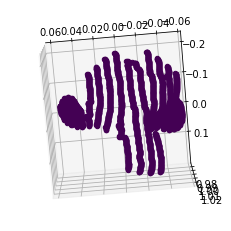

In [24]:
fig = plt.figure(figsize=(4,4))

ax = fig.add_subplot(111, projection='3d')
for points in chimp:
    for elem in points[slice(0, len(points), 3)]:
        #print(elem)
        ax.scatter(elem[0], elem[1], elem[2], c=elem[0]*255, marker='o')
ax.view_init(100,85)
plt.show()

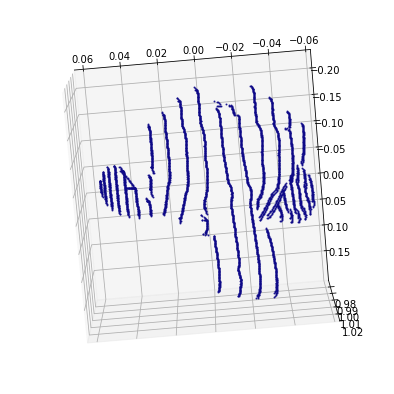

In [26]:
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
my_cmap = plt.get_cmap('plasma')
for points in chimp:
    for elem in points[slice(0, len(points), 3)]:
        #print(elem)
        ax.scatter3D(elem[0], elem[1], elem[2],s=1,alpha=0.8, c=elem[0]*255,cmap = my_cmap, marker='o')
        #ax.scatter3D(points[0],points[1],points[2], s=1, alpha = 0.8, c = (points[0]), cmap = my_cmap, marker='o')
        #ax.scatter3D(elem)    
ax.view_init(100,85)
plt.show()